CNN T=RMS images intra-session grid search. <br>
Model consists of the seven Convolutional layers and 5 FC layers.

________________________________________________________________________________
GS parameters: <br>

params = {'nbr_filters_hid1': [64, 128], <br>
                'nbr_filters_hid2': [64, 128], <br>
                'nbr_filters_hid3': [64, 128], <br>
                'nbr_filters_hid4': [64, 128], <br>
                'nbr_filters_hid5': [64, 128], <br>
                'drop_rate': [0, 0.3], <br>
                'lambda_': [1e-5,1e-1,0],
                }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.1

In [ ]:
!pip install git+https://github.com/autonomio/talos@1.0

In [ ]:
#define model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

import tensorflow as tf
import keras 

import matplotlib.pyplot as plt

def evaluation(prediction, gt, title=None, save=False, path=None,limit=None):
  """For a given predicted labels and ground truth, plots both of them.
  If set is large, use limit  (vector of two indeices) - boundaries to plot subset of the set. 
  f save, define also path as a folder and filename."""
  predicted_class=[]
  for sample in range(np.shape(prediction)[0]):
    predicted_class.append(np.argmax(prediction[sample,:]))
    #gt.append(np.argmax(desired_out[sample,:]))
  plt.figure(figsize=(20,10))
  if limit:
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(predicted_class[limit[0]:limit[1]])+1,color= '#E2A76F',linewidths=9)#'#FFA500' 
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(gt[limit[0]:limit[1]])+1,color='#26292c',marker='*',linewidths=5)
  else:
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(predicted_class)+1,color='#355C7D',linewidths=9)
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(gt)+1,color='#FFA500',marker='*',linewidths=4)

  plt.xlabel('sample',fontsize=20)
  plt.ylabel('class',fontsize=20)
  if title:
    plt.title(title)
  plt.legend(('predicted class','ground truth'),prop={'size': 27},loc=1)# bbox_to_anchor=(0.7,0.648))

  if save:
    plt.savefig(path)
  plt.show()


def create_CNN_Ameri_like_model(dim1,dim2,dim_labels = 9,  lambda_ = 1.675e-5, drop_rate = 0.1, nbr_hid1 = 80, nbr_hid2 = 24, nbr_hid3 = 24, nbr_hid4 = 24, nbr_hid5 = 24, kernel_initializer='glorot_uniform'):

    input_dim = (dim1,dim2,1)#,1)

    ######################################## CONVOLUTIONAL LAYERS ##########################################
    visible = Input(shape = input_dim)

    # First Block
    conv1 = Conv2D(16, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(visible)
    norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(norm1)
    pool1 = AveragePooling2D(pool_size = (2,2))(act1)

    # Second Block
    conv2 = Conv2D(32, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool1)
    norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(norm2)
    pool2 = AveragePooling2D(pool_size = (2,2))(act2)

    # Third Block
    conv3 = Conv2D(64, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool2)
    norm3 = BatchNormalization()(conv3)
    act3 = ReLU()(norm3)
    pool3 = AveragePooling2D(pool_size = (2,2))(act3)

   
    # Fourth Block
    conv4 = Conv2D(64, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool3)
    norm4 = BatchNormalization()(conv4)
    act4 = ReLU()(norm4)
    pool4 = AveragePooling2D(pool_size = (2,2))(act4)
    
    # Fifth Block
    conv6 = Conv2D(64, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool4)
    norm6 = BatchNormalization()(conv6)
    act6 = ReLU()(norm6)

    # Sixth Block
    conv7 = Conv2D(16, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(act6)
    norm7 = BatchNormalization()(conv7)
    act7 = ReLU()(norm7)

    # Seventh Block
    conv8 = Conv2D(16, kernel_size = (3,3), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(act6)
    norm8 = BatchNormalization()(conv8)
    act8 = ReLU()(norm8)

    ######################################## FULLY CONNECTED LAYERS #########################################

    # First
    flat = Flatten()(act8)
    hid1 = Dense(nbr_hid1, activation = 'relu', kernel_regularizer = l2(lambda_))(flat)
    drop1 = Dropout(rate = drop_rate)(hid1)

    # Second
    hid2 = Dense(nbr_hid2, activation = 'relu', kernel_regularizer = l2(lambda_))(drop1)
    drop2 = Dropout(rate = drop_rate)(hid2)

    # Third
    hid3 = Dense(nbr_hid3, activation = 'relu', kernel_regularizer = l2(lambda_))(drop2)
    drop3 = Dropout(rate = drop_rate)(hid3)

    # Fourth
    hid4 = Dense(nbr_hid4, activation = 'relu', kernel_regularizer = l2(lambda_))(drop3)
    drop4 = Dropout(rate = drop_rate)(hid4)

    # Fifth
    hid5 = Dense(nbr_hid4, activation = 'relu', kernel_regularizer = l2(lambda_))(drop4)
    drop5 = Dropout(rate = drop_rate)(hid5)


    ################################################ OUTPUT ################################################

    output = Dense(dim_labels, activation = 'softmax', kernel_regularizer = l2(lambda_))(drop5)

    model = Model(inputs = visible, outputs = output)

    optim = tf.keras.optimizers.Adam()

    # Compile model 
    model.compile(optimizer = optim, 
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def CreateFit_eng_ameri(train_generator,uselesss,valid_generator,useless,params):
    
    input_dim_r = params['nmb_rows']
    input_dim_c = params['nmb_columns']
    
    #lambda_ = params['lambda_']
    drop_rate = params['drop_rate']
    nbr_hid1 = params['nbr_filters_hid1']
    nbr_hid2 = params['nbr_filters_hid2']
    nbr_hid3 = params['nbr_filters_hid3']
    nbr_hid4 = params['nbr_filters_hid4']
    nbr_hid5 = params['nbr_filters_hid5']
    kernel_initializer = params['kernel_initializer']
    
    model = create_CNN_Ameri_like_model(input_dim_r,input_dim_c,dim_labels = 9)
    
    # Defining the callbacks we want to use
    lrate_schedule = LearningRateScheduler(step_decay)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    callbacks_list = [lrate_schedule,early_stopper]
    
    out = model.fit(train_generator, epochs = 50, verbose = 1, callbacks = callbacks_list, validation_data = valid_generator)

    #########################################
    """
    prediction = model.predict(test_generator, verbose = 0)
    pp='/content/drive/Shared drives/Nikolina/Results/Report figures/intersRMSimg.png'
    evaluation(prediction, out_test, title=None, save=True, path=pp,limit=[0,60])"""
    #########################################

    return out, model

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
session=False
"""Fil the path in the lines 2-18  and batch size in line 20"""
df_filename=['','','']
#path to train csv file folder and file name
if session:
  df_filename[0]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/train_200ms.csv"
  #path to validation csv file folder and file name
  df_filename[1]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/validation_200ms.csv"
  #path to test csv file folder and file name
  df_filename[2]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/test_200ms.csv"

  dir_=['','','']
  dir_[0]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/Train"
  dir_[1]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/Validation"
  dir_[2]="/content/drive/Shared drives/Nikolina/RMS data/Images/Session"+str(session)+"/Test"

else:
  df_filename[0]="/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/train_200ms.csv"
  #path to validation csv file folder and file name
  df_filename[1]="/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/validation_200ms.csv"
  #path to test csv file folder and file name
  df_filename[2]="/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/test_200ms.csv"
  
  dir_=['','','']
  dir_[0]="/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/Train"
  dir_[1]="/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/Validation"
  dir_[2]="/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/Test"

  print(df_filename)
  print(dir_)

#path to the folder where you want to store results
file_name='drive/Shared drives/Nikolina/Results/RMS images inter-session'

#fill the batch size
bs=32


def step_decay(epoch):
    #We half the the learning rate each 10 epochs
    initial_l_r = 0.01
    drop = 0.5
    epochs_drop = 5
    lrate = initial_l_r * np.power(drop,np.floor((1 + epoch)/epochs_drop))
    # if you want to avoid the learning rate decay, uncomment this line.
    #lrate = initial_l_r
    #print('The learning rate is : ', lrate)
    return lrate
    
#DEFINITION OF PARAMETERS 

nmb_rows=16 #define dimensions 
nmb_columns=28 #define dimensions

#TRAIN
dft=pd.read_csv(df_filename[0])
datagen=ImageDataGenerator(rescale=1/255)#
train_generator=datagen.flow_from_dataframe(dataframe=dft, 
                                            directory= dir_[0],
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5","target6","target7","target8","target9"], 
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), #tuple of integers `(height, width)
                                            batch_size=bs, 
                                            color_mode="grayscale",
                                            shuffle=True)  #shuffle is important in our case!

#VALIDATION
dfv=pd.read_csv(df_filename[1])
datagen=ImageDataGenerator(rescale=1/255)#
valid_generator=datagen.flow_from_dataframe(dataframe=dfv, 
                                            directory=dir_[1], 
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5","target6","target7","target8","target9"], 
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), 
                                            batch_size=bs,
                                            color_mode="grayscale",
                                            shuffle=True)  #shuffle is important in our case!

#TEST
#just read again with shuffle=false to make sure there is no confusion between predicted order and original labels 
dfte=pd.read_csv(df_filename[2])
datagen=ImageDataGenerator()#rescale=1/255
test_generator=datagen.flow_from_dataframe(dataframe=dfte, 
                                            directory= dir_[2], 
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5","target6","target7","target8","target9"],
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), 
                                            batch_size=bs,
                                            color_mode="grayscale",
                                            shuffle=True)

['/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/train_200ms.csv', '/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/validation_200ms.csv', '/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/test_200ms.csv']
['/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/Train', '/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/Validation', '/content/drive/Shared drives/Nikolina/RMS data/Images/Inter-session/Test']
Found 1475 validated image filenames.
Found 514 validated image filenames.
Found 514 validated image filenames.


In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64, 128],
                'nbr_filters_hid2': [64, 128],
                'nbr_filters_hid3': [64, 128],
                'nbr_filters_hid4': [64, 128],
                'nbr_filters_hid5': [64, 128],
                'drop_rate': [0, 0.3],
                'kernel_initializer':['glorot_uniform'],
                'lambda_': [1e-5,1e-1,0],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns],  
                }

import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs

parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'drive/My Drive/CNN raw results/intersVal',
                       x_val=valid_generator, y_val = 0)

Run the best model.

In [ ]:
path='/content/drive/Shared drives/Nikolina/Results/RMS images inter-session/rms_images_intersession.csv'
results=pd.read_csv(path) 

In [ ]:
val_acc=results.val_accuracy
print(max(val_acc))
best=np.where(val_acc==max(val_acc))[0]
print(best)
print(val_acc[best])

0.14396887
[130 182]
130    0.143969
182    0.143969
Name: val_accuracy, dtype: float64


In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [64],
                'nbr_filters_hid3': [64],
                'nbr_filters_hid4': [128],
                'nbr_filters_hid5': [64],
                'drop_rate': [0.3],
                'kernel_initializer':['glorot_uniform'],
                'lambda_': [1e-1],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns],  
                }

import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs
for i in range(20):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'drive/My Drive/CNN rms results/intersValid',
                        x_val=valid_generator, y_val = 0)

In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [64],
                'nbr_filters_hid3': [64],
                'nbr_filters_hid4': [128],
                'nbr_filters_hid5': [64],
                'drop_rate': [0.3],
                'kernel_initializer':['glorot_uniform'],
                'lambda_': [1e-1],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns],  
                }

import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs
for i in range(20):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'drive/My Drive/CNN rms results/intersTest',
                        x_val=test_generator, y_val = 0)

  0%|          | 0/1 [00:00<?, ?it/s]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 17 steps
Epoch 1/50
47/47 [==============================] - 6s 126ms/step - loss: 2.2102 - accuracy: 0.1173 - val_loss: 45.8706 - val_accuracy: 0.1089
Epoch 2/50
47/47 [==============================] - 4s 83ms/step - loss: 2.2044 - accuracy: 0.1349 - val_loss: 73.1121 - val_accuracy: 0.1128
Epoch 3/50
47/47 [==============================] - 4s 84ms/step - loss: 2.2013 - accuracy: 0.1383 - val_loss: 26.0009 - val_accuracy: 0.1089
Epoch 4/50
47/47 [==============================] - 4s 84ms/step - loss: 2.1993 - accuracy: 0.1207 - val_loss: 43.4707 - val_accuracy: 0.1109
Epoch 5/50
47/47 [==============================] - 4s 84ms/step - loss: 2.1863 - accuracy: 0.1505 - val_loss: 77.3016 - val_accuracy: 0.1089
Epoch 6/50
47/47 [==============================] - 4s 83ms/step - loss: 2.1841 - accuracy: 0.1553 - val_loss: 338.5568 - val_accuracy: 0.1089
Epoch 7/50
47/47 [==============================] - 4s

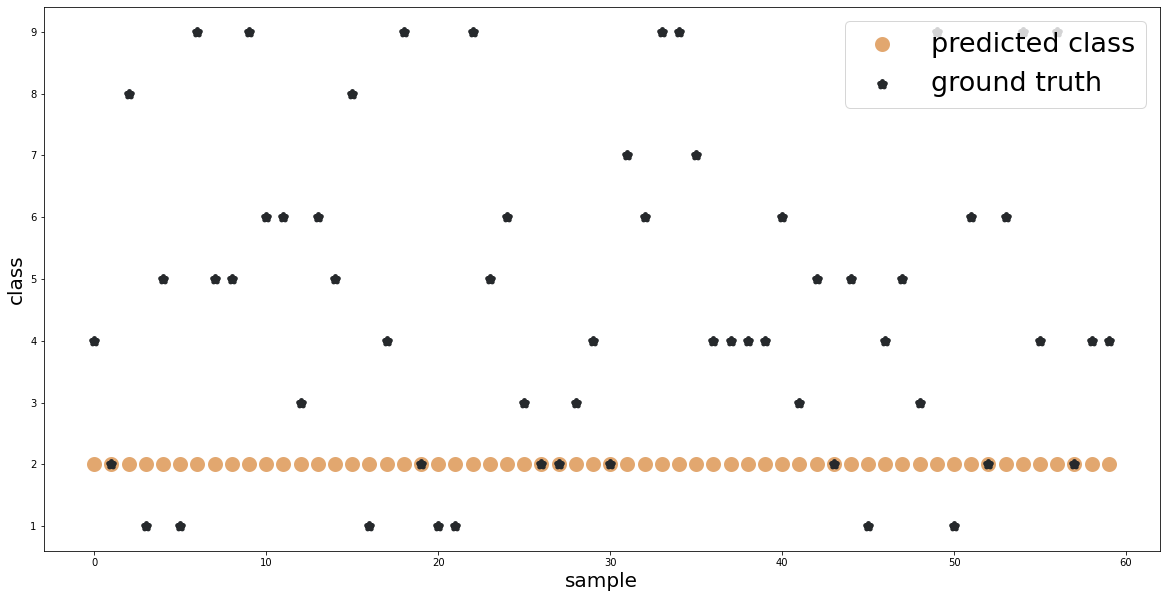

100%|██████████| 1/1 [01:34<00:00, 94.82s/it]


In [ ]:
#Grid search
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [64],
                'nbr_filters_hid3': [64],
                'nbr_filters_hid4': [128],
                'nbr_filters_hid5': [64],
                'drop_rate': [0.3],
                'kernel_initializer':['glorot_uniform'],
                'lambda_': [1e-1],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns],  
                }

import talos as ta
from talos.utils.gpu_utils import parallel_gpu_jobs
for i in range(1):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'plot',
                        x_val=test_generator, y_val = 0)

In [ ]:
predictions=[]
test_acc=[]
valid_acc=[]
train_acc=[]



# Defining the callbacks we want to use
lrate_schedule = LearningRateScheduler(step_decay)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [lrate_schedule,early_stopper]

for i in range(20):
  print('\nTraining, iteration '+ str(i))
  model = create_CNN_Ameri_like_model(nmb_rows,nmb_columns,dim_labels = 9,  lambda_ = 1e-1, drop_rate = 0.3, nbr_hid1 = 64, nbr_hid2 = 64, nbr_hid3 = 64, nbr_hid4 = 128, nbr_hid5 = 64, kernel_initializer='glorot_uniform')
  h= model.fit(train_generator, epochs = 50, verbose = 0, callbacks = callbacks_list, validation_data = valid_generator)#50 epochs
  prediction = model.predict(test_generator, verbose = 0)
  test_scores = model.evaluate(test_generator, verbose = 0)
  
  print('Train accuracy:' , h.history['accuracy'][-1])
  print('Test accuracy:',test_scores[-1])
  print('Validation accuracy:',h.history['val_accuracy'][-1])

  predictions.append(prediction)

  test_acc.append(test_scores[-1])
  train_acc.append(h.history['accuracy'][-1])
  valid_acc.append(h.history['val_accuracy'][-1])

In [ ]:
print('train accuracy: '+ str(np.mean(train_acc)) + '+-' + str(np.std(train_acc)))
print('validation accuracy: '+ str(np.mean(valid_acc)) + '+-' + str(np.std(valid_acc)))
print('test accuracy: '+ str(np.mean(test_acc)) + '+-' + str(np.std(test_acc)))

train accuracy: 0.12677965+-1.4901161e-08
validation accuracy: 0.12256809+-0.0
test accuracy: 0.12256809+-0.0


In [ ]:
out_test=list(np.where(test_generator[0][1]==1)[1])
for gen_ind in np.arange(2,len(test_generator)+1,1):
  n=(gen_ind-1)*bs
  print(gen_ind)
  out_test+=list(np.where(test_generator[gen_ind-1][1]==1)[1])
  #out_test.append(test_generator[gen_ind-1][1][:,0:9])
  #print((test_generator[gen_ind-1][1]))
print(np.shape(out_test))

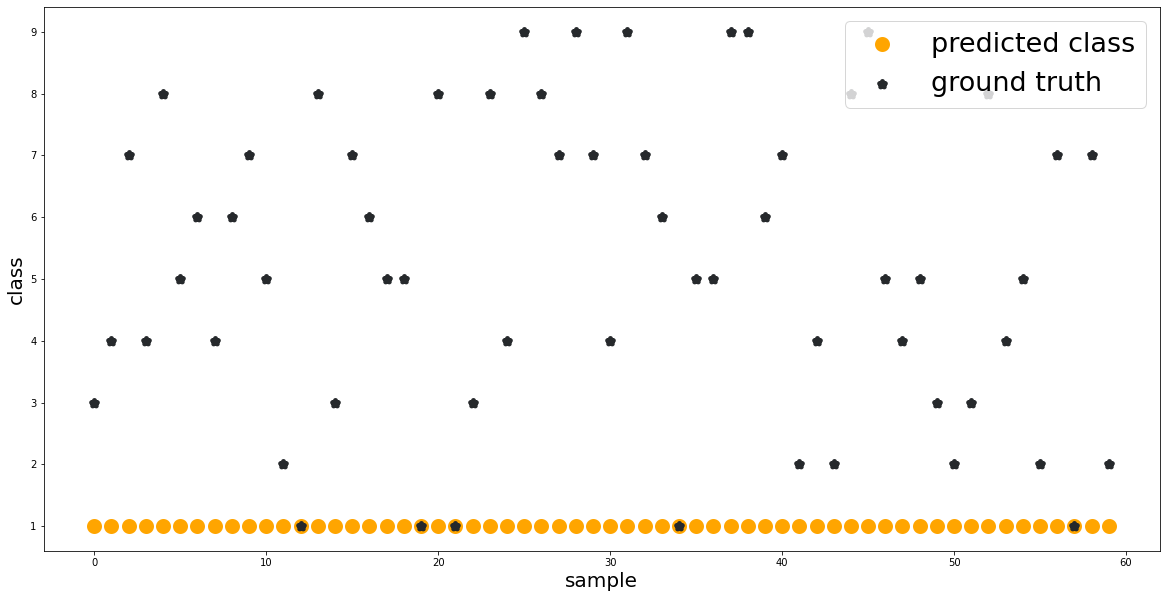

In [ ]:
pp='/content/drive/Shared drives/Nikolina/Results/Report figures/intersRMSimg.png'
evaluation(prediction, out_test, title=None, save=True, path=pp,limit=[0,60])

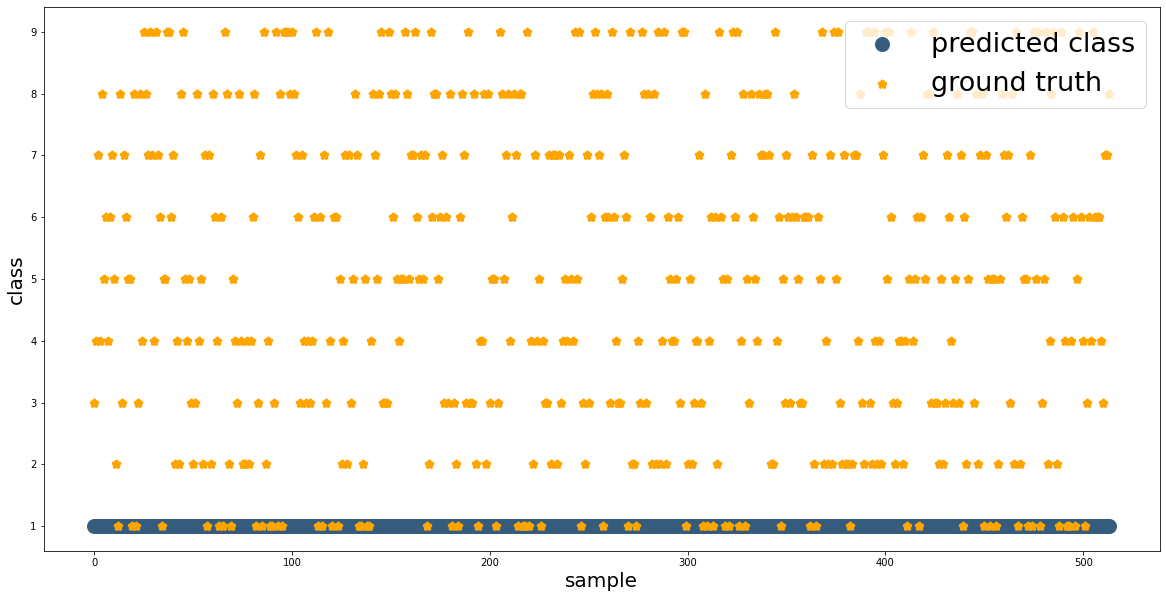

In [ ]:
evaluation(prediction, out_test, title=None, save=True, path=pp)